<a href="https://colab.research.google.com/github/antidude900/pytorch_learning/blob/main/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [ ]:
len(X),len(y)

(1000, 1000)

In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


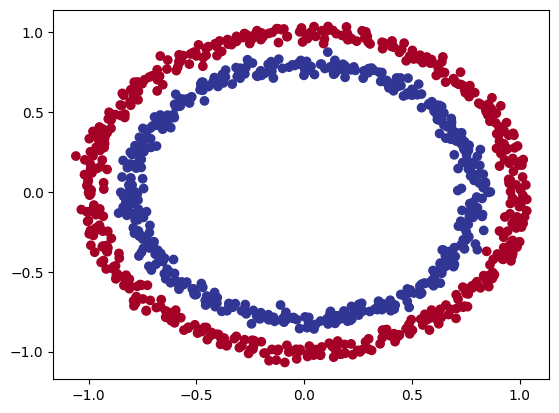

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
X.shape,y.shape

((1000, 2), (1000,))

In [ ]:
import torch

In [ ]:
X =  torch.from_numpy(X).type(torch.float)
y =  torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [ ]:
from torch import nn

device  = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(2,10),
        nn.ReLU(),
        nn.Linear(10,10),
        nn.ReLU(),
        nn.Linear(10,1),

    ).to(device)

  def forward(self,x):
    return self.layer(x)

model_0 = CircleModelV0().to(device)
model_0
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_0.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[ 0.6165,  0.0651],
                      [-0.3963,  0.6183],
                      [-0.5435,  0.2711],
                      [-0.4873, -0.1291],
                      [ 0.3230, -0.4614],
                      [ 0.6609, -0.6545],
                      [ 0.3237, -0.3211],
                      [-0.2842,  0.1038],
                      [ 0.6674, -0.2926],
                      [-0.2422,  0.0540]], device='cuda:0')),
             ('layer.0.bias',
              tensor([ 0.2483, -0.5772,  0.2405,  0.4976, -0.2459,  0.5644, -0.6248, -0.6453,
                      -0.2636, -0.3192], device='cuda:0')),
             ('layer.2.weight',
              tensor([[ 0.1476, -0.1525, -0.0594,  0.2214,  0.2530,  0.0573, -0.0888,  0.1306,
                        0.0510, -0.2481],
                      [-0.1763, -0.1262, -0.1114, -0.0294, -0.0409,  0.0882, -0.0681, -0.0498,
                       -0.0201, -0.1011],
                      [-0.0357, -0.050

In [ ]:
with torch.inference_mode():
  untrained_pred = model_0(X_test.to(device))

untrained_pred[:5],y_test[:5]

(tensor([[0.0954],
         [0.1410],
         [0.1165],
         [0.0963],
         [0.2919]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [ ]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0954],
        [0.1410],
        [0.1165],
        [0.0963],
        [0.2919]], device='cuda:0')

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5238],
        [0.5352],
        [0.5291],
        [0.5241],
        [0.5725]], device='cuda:0')

In [ ]:
y_pred =  torch.round(y_pred_probs)

In [ ]:
epochs = 20000
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs+1):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if epoch % 1000 == 0:

    model_0.eval()
    with torch.inference_mode():
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = loss_fn(test_logits,y_test)
      test_acc = accuracy_fn(y_test,test_pred)

    print(f"Epoch:{epoch} | Loss:{loss:.5f}, Acc:{acc:.2f} | Test loss:{test_loss:.5f}, Test Acc:{test_acc:.2f}")


Epoch:0 | Loss:0.69729, Acc:50.00 | Test loss:0.69707, Test Acc:50.00
Epoch:1000 | Loss:0.69004, Acc:50.25 | Test loss:0.68989, Test Acc:53.50
Epoch:2000 | Loss:0.68777, Acc:50.38 | Test loss:0.68701, Test Acc:54.50
Epoch:3000 | Loss:0.68511, Acc:57.50 | Test loss:0.68381, Test Acc:60.50
Epoch:4000 | Loss:0.68097, Acc:61.38 | Test loss:0.67869, Test Acc:63.00
Epoch:5000 | Loss:0.67516, Acc:61.50 | Test loss:0.67232, Test Acc:62.50
Epoch:6000 | Loss:0.66665, Acc:61.75 | Test loss:0.66356, Test Acc:64.50
Epoch:7000 | Loss:0.65286, Acc:68.12 | Test loss:0.64939, Test Acc:67.00
Epoch:8000 | Loss:0.62712, Acc:78.62 | Test loss:0.62562, Test Acc:81.50
Epoch:9000 | Loss:0.57612, Acc:87.88 | Test loss:0.57868, Test Acc:86.00
Epoch:10000 | Loss:0.48848, Acc:92.25 | Test loss:0.49651, Test Acc:89.50
Epoch:11000 | Loss:0.36084, Acc:96.38 | Test loss:0.37946, Test Acc:96.00
Epoch:12000 | Loss:0.22513, Acc:98.75 | Test loss:0.26000, Test Acc:99.00
Epoch:13000 | Loss:0.13792, Acc:99.75 | Test loss:0

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper function.py already exists!")
else:
  print("Downloading helper_functions.py")
  request  =  requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

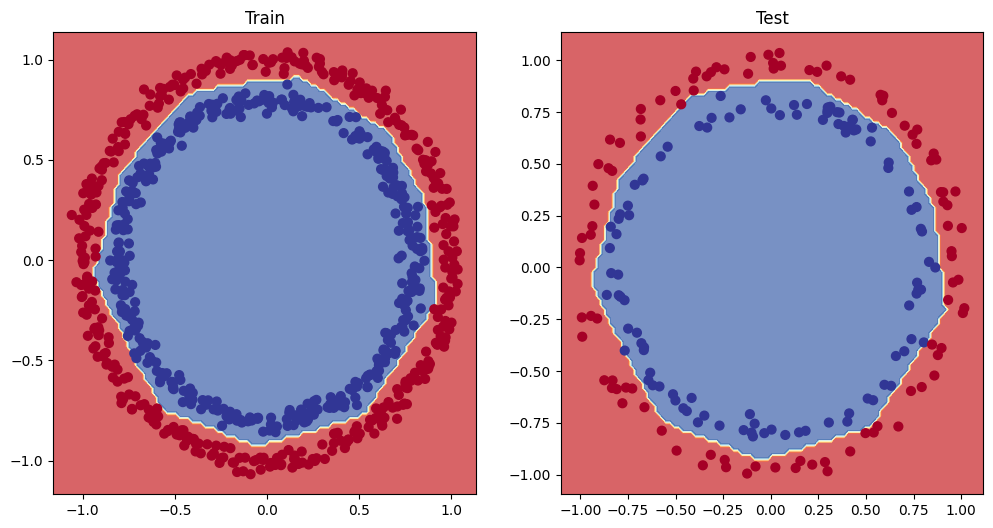

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

# Multi class classification


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


In [ ]:
x_blob,y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)
x_blob,y_blob = torch.from_numpy(x_blob).type(torch.float),torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train,x_blob_test,y_blob_train,y_blob_test =  train_test_split(x_blob,y_blob,test_size=0.2,random_state = RANDOM_SEED)


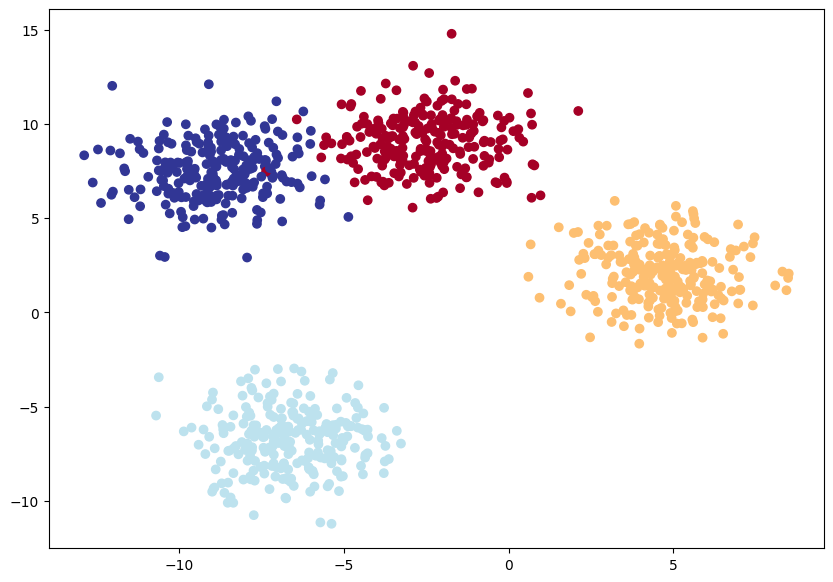

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

In [ ]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

In [ ]:
model_blob = BlobModel(input_features=2,hidden_units=8,output_features=4).to(device)
model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_blob.parameters(),lr=0.01)

In [ ]:
epochs = 20000
x_blob_train = x_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
x_blob_test = x_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

for epoch in range(epochs+1):
  model_blob.train()

  y_logits = model_blob(x_blob_train).squeeze()
  y_pred = torch.argmax(torch.sigmoid(y_logits),dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_blob_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if epoch % 1000 == 0:

    model_blob.eval()
    with torch.inference_mode():
      test_logits = model_blob(x_blob_test).squeeze()
      test_pred = torch.argmax(torch.sigmoid(test_logits),dim=1)

      test_loss = loss_fn(test_logits,y_blob_test)
      test_acc = accuracy_fn(y_blob_test,test_pred)

    print(f"Epoch:{epoch} | Loss:{loss:.5f}, Acc:{acc:.2f} | Test loss:{test_loss:.5f}, Test Acc:{test_acc:.2f}")


Epoch:0 | Loss:1.43022, Acc:26.50 | Test loss:1.40217, Test Acc:26.50
Epoch:1000 | Loss:0.03664, Acc:99.12 | Test loss:0.02717, Test Acc:99.50
Epoch:2000 | Loss:0.02834, Acc:99.12 | Test loss:0.01903, Test Acc:99.50
Epoch:3000 | Loss:0.02598, Acc:99.12 | Test loss:0.01649, Test Acc:99.50
Epoch:4000 | Loss:0.02483, Acc:99.12 | Test loss:0.01519, Test Acc:99.50
Epoch:5000 | Loss:0.02412, Acc:99.12 | Test loss:0.01432, Test Acc:99.50
Epoch:6000 | Loss:0.02362, Acc:99.12 | Test loss:0.01370, Test Acc:99.50
Epoch:7000 | Loss:0.02319, Acc:99.12 | Test loss:0.01322, Test Acc:99.50
Epoch:8000 | Loss:0.02285, Acc:99.12 | Test loss:0.01279, Test Acc:99.50
Epoch:9000 | Loss:0.02255, Acc:99.12 | Test loss:0.01241, Test Acc:99.50
Epoch:10000 | Loss:0.02227, Acc:99.12 | Test loss:0.01206, Test Acc:99.50
Epoch:11000 | Loss:0.02202, Acc:99.25 | Test loss:0.01173, Test Acc:99.50
Epoch:12000 | Loss:0.02178, Acc:99.25 | Test loss:0.01143, Test Acc:99.50
Epoch:13000 | Loss:0.02155, Acc:99.25 | Test loss:0

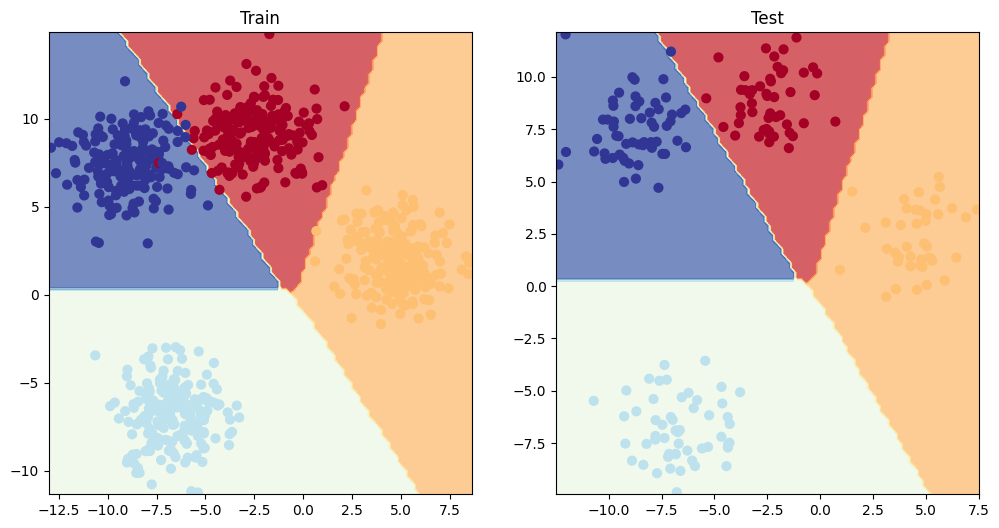

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_blob,x_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_blob,x_blob_test,y_blob_test)